In [1]:
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cbc", "highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Licensed to Bundle #6850.7319 expiring 20241231: OR 7310 Logistics, Warehousing, and Scheduling, Prof. Ergun, Northeastern University.


In [2]:
pip install amplpy matplotlib networkx


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


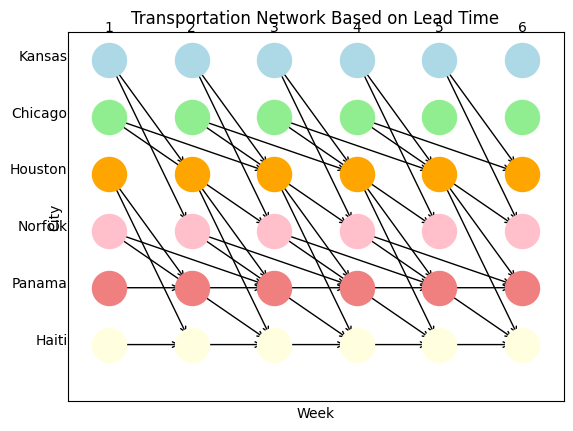

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the complete lead time connections
lead_time_data = {
    # Kansas to Houston
    ('Kansas', 1, 'Houston', 2),
    ('Kansas', 2, 'Houston', 3),
    ('Kansas', 3, 'Houston', 4),
    ('Kansas', 4, 'Houston', 5),
    ('Kansas', 5, 'Houston', 6),

    # Kansas to Norfolk
    ('Kansas', 1, 'Norfolk', 2),
    ('Kansas', 2, 'Norfolk', 3),
    ('Kansas', 3, 'Norfolk', 4),
    ('Kansas', 4, 'Norfolk', 5),
    ('Kansas', 5, 'Norfolk', 6),

    # Chicago to Houston
    ('Chicago', 1, 'Houston', 3),
    ('Chicago', 2, 'Houston', 4),
    ('Chicago', 3, 'Houston', 5),
    ('Chicago', 4, 'Houston', 6),

    # Chicago to Norfolk
    ('Chicago', 1, 'Norfolk', 3),
    ('Chicago', 2, 'Norfolk', 4),
    ('Chicago', 3, 'Norfolk', 5),
    ('Chicago', 4, 'Norfolk', 6),

    # Houston to Panama
    ('Houston', 1, 'Panama', 2),
    ('Houston', 2, 'Panama', 3),
    ('Houston', 3, 'Panama', 4),
    ('Houston', 4, 'Panama', 5),
    ('Houston', 5, 'Panama', 6),

    # Houston to Haiti
    ('Houston', 1, 'Haiti', 2),
    ('Houston', 2, 'Haiti', 3),
    ('Houston', 3, 'Haiti', 4),
    ('Houston', 4, 'Haiti', 5),
    ('Houston', 5, 'Haiti', 6),

    # Norfolk to Panama
    ('Norfolk', 1, 'Panama', 3),
    ('Norfolk', 2, 'Panama', 4),
    ('Norfolk', 3, 'Panama', 5),
    ('Norfolk', 4, 'Panama', 6),

    # Norfolk to Haiti
    ('Norfolk', 1, 'Haiti', 3),
    ('Norfolk', 2, 'Haiti', 4),
    ('Norfolk', 3, 'Haiti', 5),
    ('Norfolk', 4, 'Haiti', 6),

    # Self-connections for Panama
    ('Panama', 1, 'Panama', 2),
    ('Panama', 2, 'Panama', 3),
    ('Panama', 3, 'Panama', 4),
    ('Panama', 4, 'Panama', 5),
    ('Panama', 5, 'Panama', 6),

    # Self-connections for Haiti
    ('Haiti', 1, 'Haiti', 2),
    ('Haiti', 2, 'Haiti', 3),
    ('Haiti', 3, 'Haiti', 4),
    ('Haiti', 4, 'Haiti', 5),
    ('Haiti', 5, 'Haiti', 6),
}

# Create a directed graph
G = nx.DiGraph()

# Add edges based on the lead time data
for (src, week_src, dst, week_dst) in lead_time_data:
    G.add_edge(f"{src}, Week {week_src}", f"{dst}, Week {week_dst}")

# Define unique cities and weeks for layout
cities = ['Kansas', 'Chicago', 'Houston', 'Norfolk', 'Panama', 'Haiti']
weeks = [1, 2, 3, 4, 5, 6]

# Define colors for each city
city_colors = {
    'Kansas': 'lightblue',
    'Chicago': 'lightgreen',
    'Houston': 'orange',
    'Norfolk': 'pink',
    'Panama': 'lightcoral',
    'Haiti': 'lightyellow'
}

# Create position dictionary for nodes
pos = {}
for i, city in enumerate(cities):
    for j, week in enumerate(weeks):
        pos[f"{city}, Week {week}"] = (j, -i)  # (x, y) coordinates

# Draw nodes with specific colors for each city
for city in cities:
    nx.draw_networkx_nodes(
        G, 
        pos, 
        nodelist=[f"{city}, Week {week}" for week in weeks],
        node_color=city_colors[city],
        node_size=600  # Smaller node size
    )

# Draw week labels (only draw week numbers without repetition)
for week in weeks:
    plt.text(week - 1, 0.5, week, fontsize=10, ha='center')

# Draw edge labels
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)

# Draw node labels (only draw city names without repetition)
for city in cities:
    plt.text(-0.5, -cities.index(city), city, fontsize=10, ha='right')

# Set x and y limits
plt.xlim(-0.5, len(weeks) - 0.5)
plt.ylim(-len(cities), 0.5)

# Title and display
plt.title('Transportation Network Based on Lead Time')
plt.xlabel('Week')
plt.ylabel('City')
plt.grid(False)  # Hide grid

# Show the plot
plt.show()


In [4]:
# Optionally, you can clear any previous definitions if needed
ampl.reset()

In [5]:
from amplpy import AMPL

# Create an AMPL instance
ampl = AMPL()

# Clear any previous definitions
ampl.reset()

# Set the solver
ampl.setOption('solver', 'cbc')

# Define the AMPL model
ampl_model = """
# Sets
set CITIES;
set LINKS within (CITIES cross CITIES);

param supply {CITIES} >= 0;   # amounts available at cities
param demand {CITIES} >= 0;   # amounts required at cities

check: sum {i in CITIES} supply[i] = sum {j in CITIES} demand[j] ;

param cost {LINKS} default 0;      # shipment costs/1000 packages
param capacity {LINKS} default 0;  # max packages that can be shipped

var Ship {(i,j) in LINKS} >= 0, <= capacity[i,j];
                              # packages to be shipped

minimize Total_Cost:
   sum {(i,j) in LINKS} cost[i,j] * Ship[i,j];

subject to Balance {k in CITIES}:
   supply[k] + sum {(i,k) in LINKS} Ship[i,k]
      = demand[k] + sum {(k,j) in LINKS} Ship[k,j];

"""

# Evaluate the AMPL model
ampl.eval(ampl_model)

In [6]:
ampl_data = """
data;

set CITIES  :=  KAN1  CHI1  HOU1  NOR1  PAN1  HAI1  KAN2  CHI2  HOU2  NOR2  PAN2  HAI2  KAN3  CHI3  HOU3  NOR3  PAN3  
HAI3  KAN4  CHI4  HOU4  NOR4  PAN4  HAI4  KAN5  CHI5  HOU5  NOR5  PAN5  HAI5  KAN6  CHI6  HOU6  NOR6  PAN6  HAI6
DUM;

set LINKS   := (KAN1,HOU2) (KAN1,NOR2) (CHI1,HOU3) (CHI1,NOR3) (KAN2,HOU3) (KAN2,NOR3) (CHI2,HOU4) (CHI2,NOR4) 
(KAN3,HOU4) (KAN3,NOR4) (CHI3,HOU5) (CHI3,NOR5) (KAN4,HOU5) (KAN4,NOR5) (CHI4,HOU6) (CHI4,NOR6) (KAN5,HOU6) (KAN5,NOR6) 
(HOU1,PAN2) (HOU1,HAI2) (CHI1,PAN3) (CHI1,HAI3) (HOU2,PAN3) (HOU2,HAI3) (CHI2,PAN4) (CHI2,HAI4) (HOU3,PAN4) (HOU3,HAI4) 
(CHI3,PAN5) (CHI3,HAI5) (HOU4,PAN5) (HOU4,HAI5) (CHI4,PAN6) (CHI4,HAI6) (HOU5,PAN6) (HOU5,HAI6) (PAN1,PAN2) (PAN2,PAN3) 
(PAN3,PAN4) (PAN4,PAN5) (PAN5,PAN6) (HAI1,HAI2) (HAI2,HAI3) (HAI3,HAI4) (HAI4,HAI5) (HAI5,HAI6) (NOR1,PAN3) (NOR1,HAI3) 
(NOR2,PAN4) (NOR2,HAI4) (NOR3,PAN5) (NOR3,HAI5) (NOR4,PAN6) (NOR4,HAI6)
(KAN1, DUM) (KAN2, DUM) (KAN3, DUM) (KAN4, DUM) (CHI1, DUM) (CHI2, DUM) (CHI3, DUM) (CHI4, DUM);

param supply  default 0 :=  KAN1  200, CHI1 200, KAN2 100, CHI2 100, KAN3 50, CHI3  100, KAN4 50;

param demand  default 0 :=  PAN3  50, HAI3  50, PAN4  100, HAI4 100, PAN5 100, HAI5 200, PAN6 50, HAI6 50 DUM 100;

param:      cost  capacity  :=


  KAN1 DUM 0    300
  KAN2 DUM 0    300
  KAN3 DUM 0    300
  KAN4 DUM 0    300
  CHI1 DUM 0    300
  CHI2 DUM 0    300
  CHI3 DUM 0    300
  CHI4 DUM 0    300
  KAN1 HOU2 50    300
  KAN1 NOR2 47    300
  KAN2 HOU3 50    300
  KAN2 NOR3 47    300
  KAN3 HOU4 50    300
  KAN3 NOR4 47    300
  KAN4 HOU5 50    300
  KAN4 NOR5 47    300
  KAN5 HOU6 50    300
  KAN5 NOR6 47    300

  HOU1 PAN2 50    300
  HOU1 HAI2 60    300
  HOU2 PAN3 50    300
  HOU2 HAI3 60    300
  HOU3 PAN4 50    300
  HOU3 HAI4 60    300
  HOU4 PAN5 50    300
  HOU4 HAI5 60    300
  HOU5 PAN6 50    300
  HOU5 HAI6 60    300

  CHI1 HOU3 35    300
  CHI1 NOR3 40    300
  CHI2 HOU4 35    300
  CHI2 NOR4 40    300
  CHI3 HOU5 35    300
  CHI3 NOR5 40    300
  CHI4 HOU6 35    300
  CHI4 NOR6 40    300

  NOR1 PAN3 55    300
  NOR1 HAI3 58    300
  NOR2 PAN4 55    300
  NOR2 HAI4 58    300
  NOR3 PAN5 55    300
  NOR3 HAI5 58    300
  NOR4 PAN6 55    300
  NOR4 HAI6 58    300

  PAN1 PAN2 1     50
  PAN2 PAN3 1     50
  PAN3 PAN4 1     50
  PAN4 PAN5 1     50
  PAN5 PAN6 1     50

  HAI1 HAI2 1     50
  HAI2 HAI3 1     50
  HAI3 HAI4 1     50
  HAI4 HAI5 1     50
  HAI5 HAI6 1     50;


"""

# Load the data into AMPL
ampl.eval(ampl_data)

# Solve the model
ampl.solve()

# Display results
ampl.display('Ship')

cbc 2.10.10:cbc 2.10.10: optimal solution; objective 67100
0 simplex iterations
Ship [*,*]
# $2 = HAI2
# $11 = HOU6
# $14 = NOR4
:     DUM  $2 HAI3  HAI4  HAI5 HAI6  HOU2  HOU3  HOU4  HOU5 $11  NOR2  NOR3 $14 :=
CHI1    0   .    0    .     .    .     .    200    .     .    .    .      0   .
CHI2    0   .   .      0    .    .     .     .    100    .    .    .     .    0
CHI3    0   .   .     .      0   .     .     .     .    100   .    .     .    .
CHI4    0   .   .     .     .     0    .     .     .     .    0    .     .    .
HAI1   .    0   .     .     .    .     .     .     .     .    .    .     .    .
HAI2   .    .    0    .     .    .     .     .     .     .    .    .     .    .
HAI3   .    .   .      0    .    .     .     .     .     .    .    .     .    .
HAI4   .    .   .     .     50   .     .     .     .     .    .    .     .    .
HAI5   .    .   .     .     .     0    .     .     .     .    .    .     .    .
HOU1   .    0   .     .     .    .     .     .     .     .    .    .